In [4]:
import json
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import os
import math
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, GlobalAveragePooling2D, Flatten, Concatenate

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Loading and preprocessing

In [5]:
# Load training annotations
with open(r'/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json') as f:
    train_annotations = json.load(f)

# Load validation annotations
with open(r'/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_val2017.json') as f:
    val_annotations = json.load(f)

In [6]:
# Function to map image IDs to filenames
def get_image_filename_mapping(annotations, image_dir):
    image_filename_mapping = {}
    for image in annotations['images']:
        image_filename_mapping[image['id']] = os.path.join(image_dir, image['file_name'])
    return image_filename_mapping

train_image_dir = r'/kaggle/input/coco-2017-dataset/coco2017/train2017'
val_image_dir = r'/kaggle/input/coco-2017-dataset/coco2017/val2017'

# Create the mappings for train and validation
train_image_filename_mapping = get_image_filename_mapping(train_annotations, train_image_dir)
val_image_filename_mapping = get_image_filename_mapping(val_annotations, val_image_dir)


In [7]:
# Function to load and preprocess an image
def load_image(image_path, target_size):
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None
    img = Image.open(image_path).convert('RGB')  # Convert image to RGB
    img = img.resize(target_size, Image.Resampling.LANCZOS)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img


In [8]:
def group_captions(annotations, num_images):
    image_captions = {}
    image_ids = set()
    for annotation in annotations['annotations']:
        if len(image_ids) >= num_images:
            break
        image_id = annotation['image_id']
        caption = '<start> ' + annotation['caption'] + ' <end>'
        if image_id not in image_captions:
            image_captions[image_id] = []
            image_ids.add(image_id)
        image_captions[image_id].append(caption)
    return image_captions

# Size of training and validation
train_captions = group_captions(train_annotations, num_images=5000)
val_captions = group_captions(val_annotations, num_images=500)


In [9]:
# Remove missing images from captions
def filter_missing_images(image_captions, image_filename_mapping):
    filtered_captions = {}
    for image_id, captions in image_captions.items():
        image_path = image_filename_mapping[image_id]
        if os.path.exists(image_path):  # Only keep the image if it exists
            filtered_captions[image_id] = captions
    return filtered_captions

train_captions = filter_missing_images(train_captions, train_image_filename_mapping)
val_captions = filter_missing_images(val_captions, val_image_filename_mapping)


# Tokenizer

In [10]:
# Define special tokens
start_token = "<start>"
end_token = "<end>"
pad_token = "<pad>"

# Initialize tokenizer with the special tokens
tokenizer = Tokenizer(num_words=5000, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts([start_token, end_token, pad_token])

# Extract all captions from the training and validation annotations
all_captions = []
for captions in train_captions.values():
    all_captions.extend(captions)
for captions in val_captions.values():
    all_captions.extend(captions)

# Fit the tokenizer on the captions
tokenizer.fit_on_texts(all_captions)

# Set the pad token index to 0 for consistency
tokenizer.word_index[pad_token] = 0
tokenizer.index_word[0] = pad_token

# Create sequences
sequences = tokenizer.texts_to_sequences(all_captions)

# Pad sequences
max_length = max(len(sequence) for sequence in sequences)
sequences = pad_sequences(sequences, maxlen=max_length, padding='post')


# Data generator

In [11]:
def data_generator(image_captions, image_filename_mapping, tokenizer, max_length, batch_size):
    X1, X2, y = [], [], []

    # Loop indefinitely
    while True:
        for image_id, captions in image_captions.items():
            image_path = image_filename_mapping[image_id]
            image = safe_load_image(image_path, target_size=(224, 224))
            if image is None:
                print(f"Skipping image {image_id} due to loading error.")
                continue

            for caption in captions:
                sequence = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(sequence)):
                    in_seq, out_seq = sequence[:i], sequence[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=len(tokenizer.word_index) + 1)[0]

                    X1.append(image)
                    X2.append(in_seq)
                    y.append(out_seq)

                    if len(X1) == batch_size:
                        yield ([np.array(X1), np.array(X2)], np.array(y))
                        X1, X2, y = [], [], []

        # Yield remaining data as a batch
        if len(X1) > 0:
            yield ([np.array(X1), np.array(X2)], np.array(y))
            X1, X2, y = [], [], []

def safe_load_image(image_path, target_size):
    try:
        return load_image(image_path, target_size)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None



# Loading model

In [20]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, GlobalAveragePooling2D, Flatten, Concatenate
import tensorflow as tf

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False)

# Add a GlobalAveragePooling2D layer
cnn_output = GlobalAveragePooling2D()(base_model.output)

# Flatten the output of the base_model
cnn_output = Flatten()(cnn_output)

# Add a Dense layer to CNN output
cnn_output = Dense(256, activation='relu')(cnn_output)

# Set the base_model input as the model input
input1 = base_model.input

# Create the encoder model
encoder_model = Model(inputs=input1, outputs=cnn_output)

# Freeze the layers of the encoder model to retain pre-trained weights
for layer in encoder_model.layers:
    layer.trainable = False

# Define the RNN decoder
input2 = Input(shape=(max_length,))
decoder_embedding = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=256, mask_zero=True)(input2)
decoder_lstm = LSTM(256, return_sequences=False)(decoder_embedding)

# Combine CNN and LSTM outputs using Concatenate
combined_output = Concatenate()([cnn_output, decoder_lstm])

# Dense layers for processing combined features
combined_output = Dense(256, activation='relu')(combined_output)
final_output = Dense(len(tokenizer.word_index) + 1, activation='softmax')(combined_output)

# Combine the encoder and decoder into one model
model = Model(inputs=[input1, input2], outputs=final_output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')


94765736/94765736 [==============================] - 0s 0us/step


# Training model

In [21]:
def calculate_steps_per_epoch(image_captions, tokenizer, batch_size):
    total_input_output_pairs = 0
    for captions in image_captions.values():
        for caption in captions:
            # Tokenize the caption to get the sequence
            sequence = tokenizer.texts_to_sequences([caption])[0]
            # Add the number of input-output pairs this caption will generate
            total_input_output_pairs += len(sequence) - 1
    # The number of steps per epoch is the total pairs divided by the batch size
    return math.ceil(total_input_output_pairs / batch_size)

batch_size = 32

# Calculate the steps per epoch for training and validation
steps_per_epoch_train = calculate_steps_per_epoch(train_captions, tokenizer, batch_size)
steps_per_epoch_val = calculate_steps_per_epoch(val_captions, tokenizer, batch_size)

# Now you can use these values to set up your data generators
train_generator = data_generator(train_captions, train_image_filename_mapping, tokenizer, max_length, batch_size)
val_generator = data_generator(val_captions, val_image_filename_mapping, tokenizer, max_length, batch_size)


In [ ]:
model.fit(train_generator, 
          epochs=10, 
          steps_per_epoch=steps_per_epoch_train, 
          validation_data=val_generator, 
          validation_steps=steps_per_epoch_val,
          verbose=1
)


In [ ]:
# Assuming `model` is your trained Keras model
model.save('/kaggle/working/5000train_500val_32bs.h5')  # Save the model in HDF5 format

In [22]:
from tensorflow.keras.models import load_model

# load the model
model = load_model('/kaggle/working/5000train_500val_32bs.h5')

# LSTM Hyperparameter Bayesian Optimisation

In [26]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Define the space of hyperparameters to search
space = {
    'units': hp.choice('units', [128, 256, 512]),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01))
}

trial_number = 0

# Define the objective function
def optimize_hyperparameters(params):
    global trial_number
    trial_number += 1
    print(f'Starting trial {trial_number} with params:', params)

    # Rebuild the LSTM layer and optimizer with new hyperparameters
    decoder_lstm = LSTM(int(params['units']), return_sequences=False)(decoder_embedding)
    combined_output = Concatenate()([cnn_output, decoder_lstm])
    combined_output = Dense(256, activation='relu')(combined_output)
    final_output = Dense(len(tokenizer.word_index) + 1, activation='softmax')(combined_output)
    model = Model(inputs=[input1, input2], outputs=final_output)

    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=2)

    # Train the model
    history = model.fit(train_generator, 
                        epochs=10, 
                        steps_per_epoch=steps_per_epoch_train, 
                        validation_data=val_generator, 
                        validation_steps=steps_per_epoch_val,
                        callbacks=[early_stop],
                        verbose=2)

    # Calculate the mean validation loss
    val_loss = np.mean(history.history['val_loss'])
    print(f'Validation Loss for trial {trial_number}:', val_loss)
    return {'loss': val_loss, 'status': STATUS_OK}


In [27]:
# Run the optimization
trials = Trials()
best = fmin(optimize_hyperparameters, space, algo=tpe.suggest, max_evals=5, trials=trials)

print('Best parameters:', best)

Starting trial 1 with params:                        
{'learning_rate': 0.0017954653530754708, 'units': 256}
Epoch 1/10                                           

8742/8742 - 620s - loss: 3.8932 - val_loss: 3.7883 - 620s/epoch - 71ms/step

Epoch 2/10                                           

8742/8742 - 605s - loss: 3.3981 - val_loss: 3.8141 - 605s/epoch - 69ms/step

Epoch 3/10                                           

8742/8742 - 604s - loss: 3.2792 - val_loss: 3.9149 - 604s/epoch - 69ms/step

Validation Loss for trial 1:                         
3.8390941619873047                                   
Starting trial 2 with params:                                                      
{'learning_rate': 0.004228986385888877, 'units': 256}                              
Epoch 1/10                                                                         

8742/8742 - 624s - loss: 4.3100 - val_loss: 4.3522 - 624s/epoch - 71ms/step        

Epoch 2/10                                       

# Saving and loading the model

In [28]:
import json

def save_model_and_params(best_params, model, model_path, params_path):
    # Save the model
    model.save(model_path)
    print(f"Model saved to {model_path}")

    # Convert the best hyperparameters to a Python dictionary (if necessary)
    # and save them as a JSON file
    with open(params_path, 'w') as file:
        json.dump(best_params, file)
    print(f"Hyperparameters saved to {params_path}")

# After finding the best parameters with Hyperopt
best_params = {'units': 256, 'learning_rate': 0.001}  # Replace with your actual best params

# Assuming 'model' is your trained model
model_path = '/kaggle/working/best_model.h5'
params_path = '/kaggle/working/best_hyperparameters.json'

save_model_and_params(best_params, model, model_path, params_path)


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /kaggle/working/best_model.h5
Hyperparameters saved to /kaggle/working/best_hyperparameters.json


In [ ]:
from tensorflow.keras.models import load_model

# load the model
model = load_model('/kaggle/working/best_model.h5')

# loading best hyperparameters
#with open('/kaggle/working/best_hyperparameters.json', 'r') as file:
#    loaded_params = json.load(file)

# Inference

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def generate_caption(image_path):
    # Display the image
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers
    plt.show()
    
    start_token = tokenizer.word_index['<start>']
    end_token = tokenizer.word_index['<end>']
    image = load_image(image_path, target_size=(224, 224))
    image = np.expand_dims(image, axis=0)
    input_seq = [start_token]
    caption = []

    for i in range(max_length):
        # Convert to numpy array, pad to the expected sequence length, and add batch dimension
        input_seq_array = np.array(input_seq)[np.newaxis, :]
        input_seq_array = pad_sequences(input_seq_array, maxlen=max_length, padding='post')
        
        predictions = model.predict([image, input_seq_array], verbose=0)
        predicted_id = np.argmax(predictions[0])
        
        if predicted_id == end_token:
            break
        
        word = tokenizer.index_word.get(predicted_id, '<unk>')
        caption.append(word)
        
        # Append the predicted word id to the sequence
        input_seq.append(predicted_id)
    
    # Remove the start token from the caption
    if caption[0] == '<start>':
        caption = caption[1:]
        
    return ' '.join(caption)


In [30]:
def get_random_test_image_path():
    import os
    import random

    # Path to the test set directory
    test_set_dir = r'/kaggle/input/coco-2017-dataset/coco2017/train2017'

    # Get a list of filenames in the test set directory
    test_images = os.listdir(test_set_dir)

    # Choose a random image file
    random_image_file = random.choice(test_images)

    # Get the full path of the random image
    random_image_path = os.path.join(test_set_dir, random_image_file)

    return random_image_path


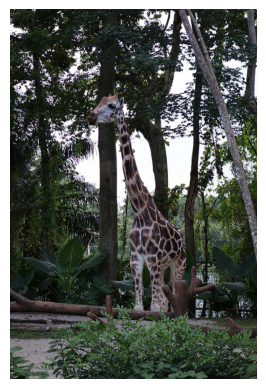

Caption for random image: a giraffe standing in a zoo enclosure in a zoo


In [33]:
# Load a random image from the test set
random_image_path = get_random_test_image_path()  # Call the function to get a random image path

# Generate a caption for the random image
caption = generate_caption(random_image_path)

# Print the caption
print('Caption for random image:', caption)

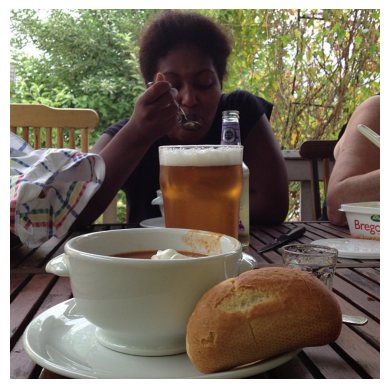

Caption for random image: a woman is standing in a kitchen with a spoon


In [51]:
# Load a random image from the test set
random_image_path = get_random_test_image_path()  # Call the function to get a random image path

# Generate a caption for the random image
caption = generate_caption(random_image_path)

# Print the caption
print('Caption for random image:', caption)